In [92]:
from model import *
import pandas as pd 
import autograd.numpy as np
from autograd import jacobian

In [93]:
direct_contribtions_fasted = [0.04, 0.24, 0.6, 0.05] # Hui et al. 2020
v_fasted = reference_fluxes(direct_contributions=direct_contribtions_fasted)

# Flux names 
flux_names = ['vL', 'vG', 'vF', 'vK', 'vGL', 'vFK', 'vLG', 'v0', 'vA', 'vR', 'vP', 'vCO2']
data = pd.DataFrame([v_fasted, ], columns=flux_names)  


In [94]:
# We do a metabolic control analysis for the fasted assuming no regulation
# of the fluxes

def non_reg_fluxes(x,p):
    L,G,F,K = x
    
    vE, omega, lam, gamma, beta, kappa, alpha, VR, KF, KG, VFK, KFK, VLG, KL, v0= p
    
    M = vE/(nG*omega*G + nL*lam*L + gamma*G + nF*beta*F + nK*kappa*K)
        
    vGL = omega*G*M
    vG = gamma*G*M
    vL = lam*L*M
    vF = beta*F*M
    vK = kappa*K*M
    
    vA = alpha
    vR = VR *  G/KG * F/KF / (1 + G/KG + F/KF)
    
    vFK = VFK * F / (F+KFK)
    vLG = VLG * L / (L+KL)
    
    v0 = v0 
    
    return np.array([vL, vG, vF, vK, vGL, vFK,  vLG, v0, vA, vR,])


def stochiometry():
    l = np.array([-1,  0,  0,  0,  2,   0, -2,   0,   0,    0, ]) # 0 
    g = np.array([ 0, -1,  0,  0, -1,   0,  1,   1, 0.5, -0.5, ]) # 0
    f = np.array([0 ,  0, -1,  0,  0,  -1,  0,   0,   3,   -3, ]) # 0 
    k = np.array([0 ,  0,  0, -1,  0,   4,  0,   0,   0,    0, ]) # 0
    return np.vstack([l, g, f, k])


In [95]:
def steady_state_parameters(v,x,Km):
    
    vE = 1
    # Calculate parameters for the steady state
    L,G,F,K = x
    vL, vG, vF, vK, vGL, vFK, vLG, v0, vA, vR = v
    KF, KG, KFK, KL= Km

    # Calculate the parameters
    omega = vGL/G
    lam = vL/L
    gamma = vG/G
    beta = vF/F
    kappa = vK/K
    alpha = vA

    # Calculate the Vmaxes
    VR = vR / (G/KG * F/KF / (1 + G/KG + F/KF))
    VFK = vFK / (F/(F+KFK))
    VLG = vLG / (L/(L+KL))

    v0 = v0

    return np.array([vE, omega, lam, gamma, beta, kappa, alpha, VR, KF, KG, VFK, KFK, VLG, KL, v0,])

In [96]:
# Calculate the control coefficients
def control_coeffcients(v0,x0,Km):
    # Get staeaady state parameters
    p0 = steady_state_parameters(v0,x0,Km)

    E = jacobian(lambda x: non_reg_fluxes(x,p0))(x0)
    P = jacobian(lambda p: non_reg_fluxes(x0,p))(p0)

    # Normalize the partial derivatives
    V = np.diag(np.array(v0)) 
    X = np.diag(np.array(x0))
    E = np.diag(1/np.array(v0)) @ E @ np.diag(x0)
    P = np.diag(1/np.array(v0)) @ P @ np.diag(p0)

    S = stochiometry()

    CX = - np.linalg.inv(S @ V @ E) @ (S @ V @ P )
    CV = E @ CX + P

    return CX, CV

In [97]:
# Calculate the control coefficients
x0 = np.array([1.0, 1.0, 1.0, 1.0])
v0 = v_fasted[:-2] 
Km = [1.0, 0.1, 0.1, 0.1]

CX, CV = control_coeffcients(v0,x0,Km)

In [98]:

# vE, omega, lam, gamma, beta, kappa, alpha, VR, KF, KG, VFK, KFK, VLG, KL, v0
parameter_names = ['vE', 'omega', 'lam', 'gamma', 'beta', 'kappa', 'alpha', 'VR', 'KF', 'KG', 'VFK', 'KFK', 'VLG', 'KL', 'v0']
    
flux_parameters = ['omega', 'lam', 'gamma', 'beta', 'kappa', 'alpha', 'VR', 'VLG', 'v0']
flux_parameter_indices = [parameter_names.index(p) for p in flux_parameters]


concentration_control_coefficients = pd.DataFrame(CX[:,flux_parameter_indices].T, columns=['L','G','F', 'K'], index=flux_parameters)

flux_control_coefficients = pd.DataFrame(CV[:,flux_parameter_indices].T, columns=flux_names[:-2], index=flux_parameters)

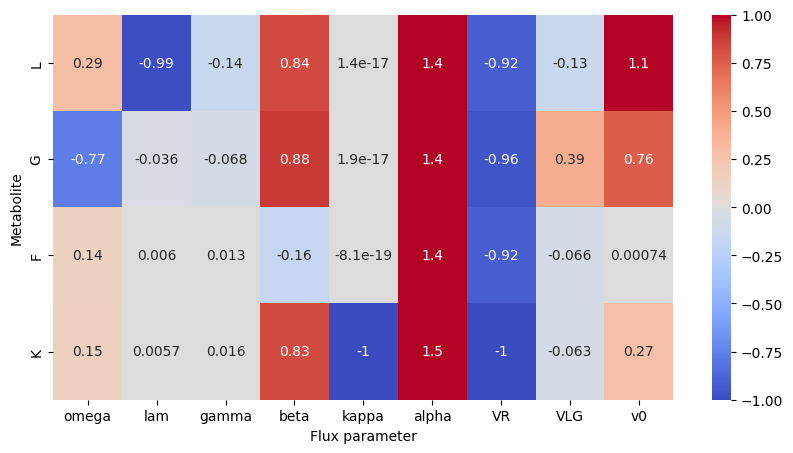

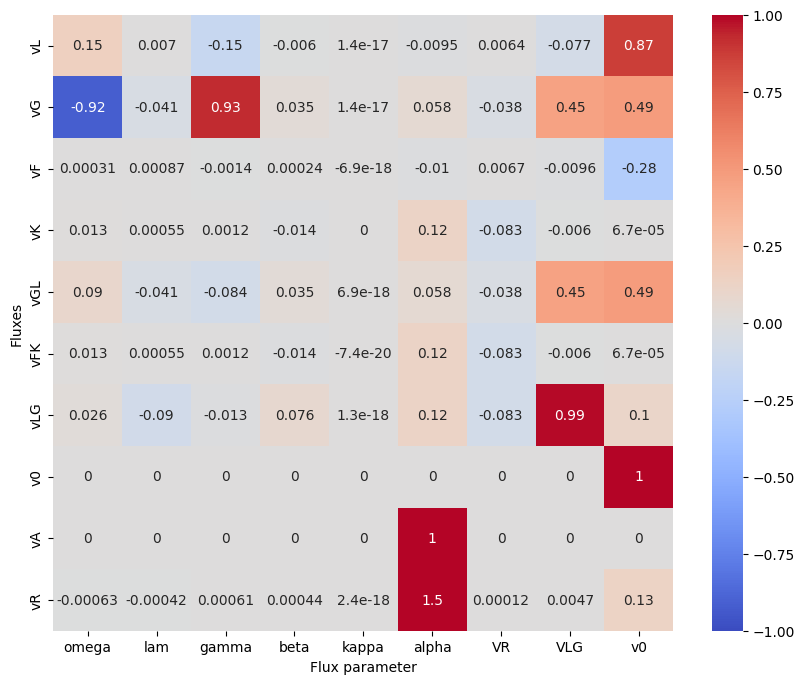

In [105]:
# Plot heat map
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(concentration_control_coefficients.T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.ylabel('Metabolite')
plt.xlabel('Flux parameter')

plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(flux_control_coefficients.T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.ylabel('Fluxes')
plt.xlabel('Flux parameter')

plt.show()

array([0.9865614 , 0.98505352, 0.99667448, 0.984453  ])

In [101]:
# Control coefficients
def control_coefficients(v,x,p):
    #concentration_elasticities = d fluxes / d concentrations * concentrations / fluxes
    
    return C